# Step 1 – Data Pre-processing and management:

## Generate a spectrogram from a file
Do imports first

In [67]:
#import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
# to enable zooming in matplotlib in notebook
#%matplotlib notebook
#conda install -c conda-forge ipympl # or pip install ipympl #This is to allow zooming in the notebook
#matplotlib ipympl
import tensorflow as tf     #pip install tensorflow
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

## Call Type : RUPE B

Name audio and annotation file that you want to import (without the extensions), then read in the audio and annotations

In [68]:
#File index
file =  '5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file = 'Rupes A and B\\5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file = 'Guttural rupe\\5711.211013040024'
#file = 'Rupes A and B\\5713.210825190002'
#file =          'Moan\\5713.210902110002'  #from PPT at time 212 seconds

#Read the 2 files
sample_rate, samples = wavfile.read(file+'.wav')
annot_file_path = file +'.Table.1.selections.txt'

#Read the file into a DataFrame
df = pd.read_csv(file +'.Table.1.selections.txt', sep='\t')

#Display the first few rows of the DataFrame
#print(df.head())
print(df)

    Selection           View  Channel  Begin Time (s)  End Time (s)  \
0           1  Spectrogram 1        1      871.984579    872.045877   
1           2  Spectrogram 1        1      872.605082    872.730809   
2           3  Spectrogram 1        1      873.525329    873.616653   
3           4  Spectrogram 1        1      874.776471    874.904325   
4           5  Spectrogram 1        1      876.693356    876.876005   
5           6  Spectrogram 1        1      877.095183    877.364589   
6           7  Spectrogram 1        1      884.521098    884.664983   
7           8  Spectrogram 1        1      887.606950    887.981380   
8           9  Spectrogram 1        1      891.800005    892.179001   
9          10  Spectrogram 1        1      892.539731    893.119640   
10         11  Spectrogram 1        1      893.553430    893.927859   
11         12  Spectrogram 1        1      894.343384    894.576261   
12         13  Spectrogram 1        1      895.302288    895.768042   
13    

### Calculate the Spectrogram

In [69]:
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=2456, nfft=4096, noverlap=1228, window='hann')       #Try nfft=8192 if computer permits

In [70]:
#fmax = max(df['High Freq (Hz)'])
#fmax

In [71]:
#fmin = min(df['Low Freq (Hz)'])
#fmin

In [72]:
#time = df['End Time (s)'] - df['Begin Time (s)']
#max_time = max(time)
#max_time

With the resultsing spectrogram, trim all the tiny values so that log scale displays correctly. Also, all of the relevant info is below 1KHz so trim the data to only display sub 1-KHz frequencies

In [73]:
spectrogram[spectrogram < 0.001] = 0.001    #Trim off all the tiny values so that log scale displays correctly

#Trim in frequency
fmin = 20 # Hz
fmax = 1000 # Hz
freq_slice = np.where((frequencies >= fmin) & (frequencies <= fmax))

#keep only frequencies of interest
frequencies = frequencies[freq_slice]
spectrogram = spectrogram[freq_slice,:][0]

Next I'm going to define a function that will overlay the annotated rectangles onto the spectrogram (different colours for each call)

In [74]:
def overlay_annotations(ax, df, annotation_colors):
    #Track labels to ensure they are added only once in the legend
    added_labels = set()

    for _, row in df.iterrows():
        start_time = row['Begin Time (s)']
        end_time = row['End Time (s)']
        low_freq = row['Low Freq (Hz)']
        high_freq = row['High Freq (Hz)']
        annotation = row['Annotation']

        #Skip if the annotation is not in the defined colors
        if annotation not in annotation_colors:
            continue

        #Draw rectangles
        ax.add_patch(
            plt.Rectangle(
                (start_time, low_freq),  #Bottom Left corner
                end_time - start_time,  #Width (time)
                high_freq - low_freq,  #Height (frequency)
                edgecolor=annotation_colors[annotation],
                facecolor='none',
                linewidth=2,
                label=annotation if annotation not in added_labels else None  #Add label once
            )
        )
        added_labels.add(annotation)  #Mark label as added

    ax.legend(loc='upper right')     #Add legend

I've also written a function below that updates the colormap when you zoom in on a particular region - so that the max and min values are always visible

In [75]:
def update_colormap(event):
    #Get current view limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    #Find indices corresponding to the current view limits
    x_indices = np.where((times >= xlim[0]) & (times <= xlim[1]))[0]
    y_indices = np.where((frequencies >= ylim[0]) & (frequencies <= ylim[1]))[0]

    #Handle cases where no data is visible
    if len(x_indices) == 0 or len(y_indices) == 0:
        return

    #Extract the visible data
    data_visible = spectrogram[np.ix_(y_indices, x_indices)]
    #data_visible = np.log(spectrogram)[np.ix_(y_indices, x_indices)]

    #Compute new color limits
    vmin = np.nanmin(data_visible)
    vmax = np.nanmax(data_visible)

    #Update the color limits of the pcolormesh
    pc.set_clim(vmin=vmin, vmax=vmax)

    #Update the colorbar to reflect the new color limits
    cbar.update_normal(pc)

    #Redraw the figure
    plt.draw()


Ok, let's plot the spectrogram and annotations

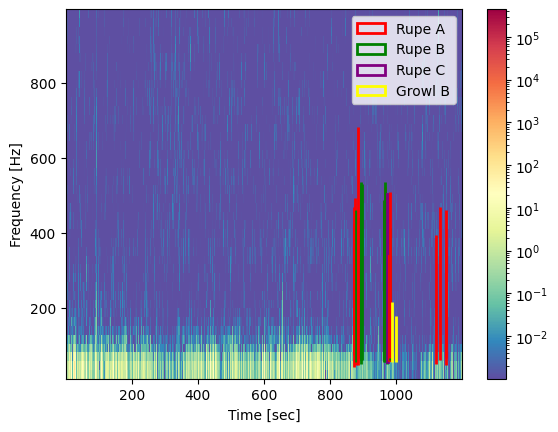

In [76]:
#Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C" : "purple",
    "Moan": "pink",
    "G rupe" : "blue"
}

pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
#pc = plt.pcolormesh(times, frequencies, np.log(spectrogram))
cbar = plt.colorbar(pc)
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#Get the current axes
ax = plt.gca()
overlay_annotations(ax, df, annotation_colors)

#Connect the update function to the axes limit change events
ax.callbacks.connect('xlim_changed', update_colormap)
ax.callbacks.connect('ylim_changed', update_colormap)

plt.show()

Note : As you can see in the spectogram above for file 5713.210809120002, there are no calls between 400 seconds and 800 seconds.

Extract out a portion of interest from the spectrogram when you can hear a RUPE B call

I'm going to extract a single call now and check the size of the spectrogram array

(25, 469)


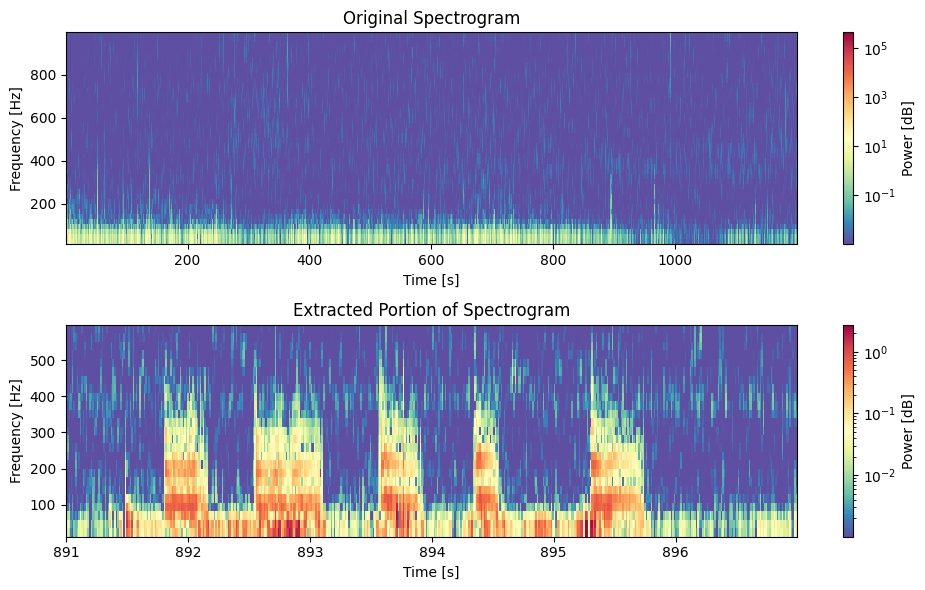

In [77]:
#Define time and frequency limits
time_start, time_end = 891, 897  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
#time_indices = np.where((times >= time_start) & (times <= time_end))[0]

#Find indices for the time range
# The original condition resulted in an empty array
# time_indices = np.where((times >= time_start) & (times <= time_end))[0]
# Let's find the closest time indices to the desired range
time_indices = np.where(np.logical_and(times >= time_start, times <= time_end))[0]
# If the above results in an empty array, find the nearest indices:
if len(time_indices) == 0:
    time_indices = np.where(np.abs(times - (time_start + time_end) / 2) < (time_end - time_start) / 2)[0]
    closest_time_index = np.argmin(np.abs(times - (time_start + time_end) / 2))
    time_indices = np.array([closest_time_index])  # Create an array with the closest index
#Find indices for the frequency range
#freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]


#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print(spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()

Spectrogram size:  (25, 55)


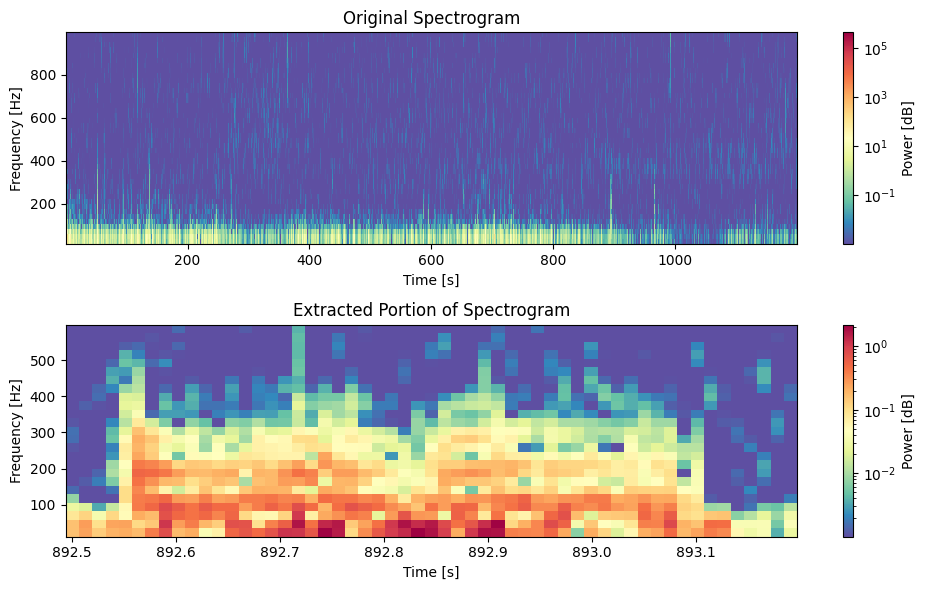

In [78]:
#Define time and frequency limits
time_start, time_end = 892.5, 893.2  # Time range in seconds
#time_start, time_end = 892.5, time_end  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
#time_indices = np.where((times >= time_start) & (times <= time_end))[0]
# Let's find the closest time indices to the desired range
time_indices = np.where(np.logical_and(times >= time_start, times <= time_end))[0]
# If the above results in an empty array, find the nearest indices:
if len(time_indices) == 0:
    closest_time_index = np.argmin(np.abs(times - time_start)) #Changed time_start to be the desired start time for plotting
    time_indices = np.array([closest_time_index])  # Create an array with the closest index

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub_rupe_b = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print("Spectrogram size: ", spectrogram_sub_rupe_b.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub_rupe_b, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()

In [79]:
df['Spectogram'] = None
#print(df.head())

In [80]:
#df.Spectogram[1]

Try and save the spectrogram plot. (I wouldn't actually do this in practice - I would save the extracted spectrogram as raw data to be used for ML)

## Call Type : No Call

As you can see in the spectogram above for file 5713.210809120002, there are no calls between 875.0 seconds and 876.5 seconds.
Lets do a spectogram of a no call between 400.5 seconds and 401.2 seconds

In [81]:
row_df = pd.DataFrame(columns=df.columns)
#row_df = row_df.drop(["No Call Spectogram"],axis=1)
row_df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,Spectogram


In [82]:
insert_loc=0
for index, row in df.iterrows():
    #print(index)
    #df[]
    if index == (max(df.index)):
        quit
    #elif index % 2 != 0:
        #continue
    else:
        #print((df['Begin Time (s)'][index+1])-(df['End Time (s)'][index]))
        #no_call_time = start_time - end_time
        #low_freq = min_frequency
        #high_freq = max_frequency
        #annotation = 'no call'
        #time_indices = np.where((times >= time_start) & (times <= time_end))[0]

        #Find indices for the frequency range
        #freq_indices = np.where((frequencies >= low_freq) & (frequencies <= high_freq))[0]

        #Extract the portion of the spectrogram
        #spectrogram_sub = spectrogram[freq_indices][:, time_indices]
        #frequencies_sub = frequencies[freq_indices]
        #times_sub = times[time_indices]
        #print(spectrogram_sub.shape)
        #df.loc[index] = df[{Annotation:'No Call'}]
        #print(time_start, time_end)
        time_end = df['Begin Time (s)'][index+1]
        time_start = df['End Time (s)'][index]
        row=["","","",time_start,time_end,"","","","","","No Call",""]
        #row=pd.Series(row)
        #row_df = pd.DataFrame([row],columns=df.columns)
        #insert_loc = df.index.max()
        row_df.loc[index] = row
        #df.loc[index+1] = df.loc[index+2]
        #df.loc[index+1] = row
        #df = df.sort_index()
        #df = df.reset_index(drop = True)
        #df.index = range(len(df))
        #df = df.sort_index()
        #df = df.append(pd.DataFrame(row,ignore_index=True))
        #df.index = (df.index + 1) % len(df)
        #df = df.sort_index()
        #a_row = pd.Series(row)
        #row_df = pd.DataFrame(row,columns=df.columns)
        #row_df = pd.concat([row_df, row], ignore_index=True)
        #df = pd.concat([pd.DataFrame([row],columns=df.columns),df],ignore_index=False)

In [83]:
row_df.head()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,Spectogram
0,,,,872.045877,872.605082,,,,,,No Call,
1,,,,872.730809,873.525329,,,,,,No Call,
2,,,,873.616653,874.776471,,,,,,No Call,
3,,,,874.904325,876.693356,,,,,,No Call,
4,,,,876.876005,877.095183,,,,,,No Call,


In [84]:
df = pd.concat([df, row_df], ignore_index=True)
df = df.sort_values(by=['Begin Time (s)'])
df = df.reset_index(drop = True)
df.head()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,Spectogram
0,1,Spectrogram 1,1,871.984579,872.045877,75.224,426.862,0.0613,351.638,-97.26,Rupe A,None
1,,,,872.045877,872.605082,,,,,,No Call,
2,2,Spectrogram 1,1,872.605082,872.730809,42.314,470.151,0.1257,427.837,-84.86,Rupe A,None
3,,,,872.730809,873.525329,,,,,,No Call,
4,3,Spectrogram 1,1,873.525329,873.616653,65.821,493.658,0.0913,427.837,-90.74,Rupe A,None


In [85]:
df = df.drop(df[df.Annotation == 'Rupe A'].index)
df = df.drop(df[df.Annotation == 'Rupe C'].index)
df = df.drop(df[df.Annotation == 'Growl B'].index)
df = df.sort_values(by=['Begin Time (s)'])
df = df.reset_index(drop = True)
df.head()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,Spectogram
0,,,,872.045877,872.605082,,,,,,No Call,
1,,,,872.730809,873.525329,,,,,,No Call,
2,,,,873.616653,874.776471,,,,,,No Call,
3,,,,874.904325,876.693356,,,,,,No Call,
4,,,,876.876005,877.095183,,,,,,No Call,


In [86]:
df['NPZ'] = None

In [87]:
for index, row in df.iterrows():
  if df.Annotation[index] == 'Rupe B':
    start_time = row['Begin Time (s)']
    end_time = row['End Time (s)']
    low_freq = row['Low Freq (Hz)']
    high_freq = row['High Freq (Hz)']
    annotation = row['Annotation']
    time_indices = np.where((times >= start_time) & (times <= end_time))[0]
    freq_indices = np.where((frequencies >= low_freq) & (frequencies <= high_freq))[0]

    #Extract the portion of the spectrogram
    spectrogram_sub = spectrogram[freq_indices][:, time_indices]
    frequencies_sub = frequencies[freq_indices]
    times_sub = times[time_indices]
    print(spectrogram_sub.shape)
    df['Spectogram'][index] = spectrogram_sub
    np.savez('./rupe_b%i' %index, spectrogram_sub)
    npz = np.load('rupe_b%i.npz' %index)
    df['NPZ'][index] = npz
    #pd.DataFrame.from_dict({item: [npz[item]] for item in npz.files}, orient='index')
  else:
    start_time = row['Begin Time (s)']
    end_time = row['End Time (s)']
    #low_freq = df['Low Freq (Hz)'].mean()
    low_freq = 42
    #high_freq = df['High Freq (Hz)'].mean()
    high_freq = 650
    annotation = row['Annotation']
    time_indices = np.where((times >= start_time) & (times <= end_time))[0]


    #Find indices for the frequency range
    freq_indices = np.where((frequencies >= low_freq) & (frequencies <= high_freq))[0]

    #Extract the portion of the spectrogram
    spectrogram_sub = spectrogram[freq_indices][:, time_indices]
    frequencies_sub = frequencies[freq_indices]
    times_sub = times[time_indices]
    print(spectrogram_sub.shape)
    df['Spectogram'][index] = spectrogram_sub
    np.savez('./no_call%i' %index, spectrogram_sub)
    npz = np.load('no_call%i.npz' %index)
    df['NPZ'][index] = npz

(26, 44)
(26, 62)
(26, 91)
(26, 140)
(26, 17)
(17, 21)
(26, 560)
(26, 230)
(16, 29)
(26, 299)
(17, 29)
(26, 29)
(18, 45)
(26, 34)
(20, 29)
(26, 33)
(20, 18)
(26, 57)
(20, 36)
(26, 5235)
(18, 33)
(26, 27)
(17, 27)
(26, 47)
(26, 89)
(20, 23)
(26, 469)
(17, 42)
(26, 49)
(26, 426)
(26, 31)
(15, 26)
(26, 133)
(26, 375)
(26, 882)
(26, 9543)
(26, 832)
(26, 1425)
(26, 18)
(26, 0)


In [88]:
df.head()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,Spectogram,NPZ
0,,,,872.045877,872.605082,,,,,,No Call,"[[0.057631, 1.3727059, 3.0080183, 0.7726383, 0...",(arr_0)
1,,,,872.730809,873.525329,,,,,,No Call,"[[0.010278339, 0.019952955, 0.11724836, 0.0380...",(arr_0)
2,,,,873.616653,874.776471,,,,,,No Call,"[[0.04746356, 0.058675557, 0.019305225, 0.0504...",(arr_0)
3,,,,874.904325,876.693356,,,,,,No Call,"[[0.29560032, 0.13917291, 0.03703087, 0.100523...",(arr_0)
4,,,,876.876005,877.095183,,,,,,No Call,"[[0.001559826, 0.0033771866, 0.014699242, 0.09...",(arr_0)


In [89]:
#npz = np.load('*.npz')
#df= pd.DataFrame.from_dict({item: npz[item] for item in npz.files}, orient='index')

In [90]:
df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,Spectogram,NPZ
0,,,,872.045877,872.605082,,,,,,No Call,"[[0.057631, 1.3727059, 3.0080183, 0.7726383, 0...",(arr_0)
1,,,,872.730809,873.525329,,,,,,No Call,"[[0.010278339, 0.019952955, 0.11724836, 0.0380...",(arr_0)
2,,,,873.616653,874.776471,,,,,,No Call,"[[0.04746356, 0.058675557, 0.019305225, 0.0504...",(arr_0)
3,,,,874.904325,876.693356,,,,,,No Call,"[[0.29560032, 0.13917291, 0.03703087, 0.100523...",(arr_0)
4,,,,876.876005,877.095183,,,,,,No Call,"[[0.001559826, 0.0033771866, 0.014699242, 0.09...",(arr_0)
5,6,Spectrogram 1,1,877.095183,877.364589,56.418,460.748,0.2694,404.33,-89.1,Rupe B,"[[0.06893587, 0.017802723, 0.33629906, 0.26596...",(arr_0)
6,,,,877.364589,884.521098,,,,,,No Call,"[[0.046621304, 0.19203018, 0.20110828, 0.06271...",(arr_0)
7,,,,884.664983,887.606950,,,,,,No Call,"[[0.37586176, 0.35499033, 0.24277472, 0.095271...",(arr_0)
8,8,Spectrogram 1,1,887.606950,887.981380,65.821,441.942,0.3744,376.121,-86.11,Rupe B,"[[0.46774605, 0.42681628, 0.33728835, 0.930701...",(arr_0)
9,,,,887.981380,891.800005,,,,,,No Call,"[[0.33044147, 0.11492856, 0.5181928, 1.0208706...",(arr_0)


In [91]:
df.describe()

,Begin Time (s),End Time (s)
count,40.000000,40.000000
mean,946.263226,946.513169
std,77.710012,77.386499
min,872.045877,872.605082
25%,890.845349,890.845349
50%,929.252194,929.252194
75%,975.174386,974.711805
max,1150.412852,1150.321528


In [92]:
df.NPZ.dtype

dtype('O')

In [93]:
len(df)

40

### TRAIN TEST SPLIT

In [94]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1138)

In [97]:
#X = spectrogram_sub[0:26]
X = df.Spectogram[0:(len(df)-1)]
#X = df.Spectogram
y = df.Annotation[0:(len(df)-1)]
#y = df.Annotation[0:42]
#y = df.Annotation
# Instead of selecting the first element of 'Annotation', use a label for the single sample
#y = np.array([df.Annotation[0]])  # Assuming you want to use the first annotation as the label
#Reshape X before train_test_split to add a sample dimension
#X = X.reshape(25, spectrogram_sub.shape[25], spectrogram_sub.shape[55])  # Reshape to (samples, 25, 55)

# Reshape X to have the correct number of samples
# Assuming you have 25 samples, each with 25x55 features
# If the number of samples is different, adjust the first dimension accordingly
#X = X.reshape(1, spectrogram_sub.shape[0], spectrogram_sub.shape[1])

#Now proceed with the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1138)

print(y)
numberofclasses = np.unique(y).size
print("numberofclasses: ", numberofclasses)

0     No Call
1     No Call
2     No Call
3     No Call
4     No Call
5      Rupe B
6     No Call
7     No Call
8      Rupe B
9     No Call
10     Rupe B
11    No Call
12     Rupe B
13    No Call
14     Rupe B
15    No Call
16     Rupe B
17    No Call
18     Rupe B
19    No Call
20     Rupe B
21    No Call
22     Rupe B
23    No Call
24    No Call
25     Rupe B
26    No Call
27     Rupe B
28    No Call
29    No Call
30    No Call
31     Rupe B
32    No Call
33    No Call
34    No Call
35    No Call
36    No Call
37    No Call
38    No Call
Name: Annotation, dtype: object
numberofclasses:  2


### SEQUENTIAL TENSOR FLOW KERAS MODEL

In [98]:
#model.summary()

### COMPILE MODEL

### FIT MODEL

In [99]:
#history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

In [100]:
# Convert string labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df.Annotation)

# Now use the encoded labels for train-test split
X = df.Spectogram
y = y_encoded  # Use the encoded labels
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1138)


In [101]:
#https://stackoverflow.com/questions/77026495/value-error-when-predicting-using-my-model
# Ensure all spectrograms have the same shape
# Find the maximum shape among ALL spectrograms in df.Spectogram
max_shape = (0, 0)  # Initialize max_shape
for spec in df.Spectogram:
    if isinstance(spec, np.ndarray) and spec.ndim > 1:
        max_shape = tuple(max(max_shape[i], spec.shape[i]) for i in range(2))  # Update max_shape

# If all spectrograms are empty or have zero dimensions, set a default max_shape
# Modified this part to handle cases where max_shape is (26, 0)
if max_shape == (0, 0) or max_shape[1] == 0:
    max_shape = (26, 1)  # Or any other suitable default shape with a non-zero second dimension

# Pad with zeros to match max_shape
X_train = [np.pad(spec, [(0, max_shape[0] - spec.shape[0]), (0, max_shape[1] - spec.shape[1])], mode='constant')
           if isinstance(spec, np.ndarray) and spec.ndim > 1 and spec.shape[0] <= max_shape[0] and spec.shape[1] <= max_shape[1] #Check if spec shape is less than or equal to max_shape before padding
           else np.zeros(max_shape)
           for spec in X_train]
X_test = [np.pad(spec, [(0, max_shape[0] - spec.shape[0]), (0, max_shape[1] - spec.shape[1])], mode='constant')
          if isinstance(spec, np.ndarray) and spec.ndim > 1 and spec.shape[0] <= max_shape[0] and spec.shape[1] <= max_shape[1]#Check if spec shape is less than or equal to max_shape before padding
          else np.zeros(max_shape)
          for spec in X_test]

# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Update the input shape of the Flatten layer
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=max_shape)) # Use max_shape here
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(numberofclasses, activation='softmax'))

# Recompile the model after changing the input shape
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
#https://medium.com/@thedatabeast/tensorflow-neural-network-for-glm-logistic-regression-47fadba204f4
# Now you can fit the model
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.6907 - val_accuracy: 1.0000 - val_loss: 0.5705
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step - accuracy: 1.0000 - loss: 0.6495 - val_accuracy: 1.0000 - val_loss: 0.4315
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step - accuracy: 1.0000 - loss: 0.5925 - val_accuracy: 1.0000 - val_loss: 0.3238
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step - accuracy: 1.0000 - loss: 0.5410 - val_accuracy: 1.0000 - val_loss: 0.2448
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step - accuracy: 1.0000 - loss: 0.4923 - val_accuracy: 1.0000 - val_loss: 0.1899
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step - accuracy: 1.0000 - loss: 0.4448 - val_accuracy: 1.0000 - val_loss: 0.1516
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step - accuracy: 1.0000 - loss: 0.3971 - val_accuracy: 1.0000 - val_loss: 0.1237
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3500 - val_accuracy: 1.0000 - val_loss: 0.101

In [102]:
#plt.imshow(spectrogram_sub)

In [103]:
#X_test

In [104]:
X_test.dtype

dtype('float32')

In [105]:
y_pred = model.predict(X_test)
y_pred[0]
#y_pred[6].max()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


array([4.384130e-06, 9.999955e-01], dtype=float32)

In [106]:
y_pred

array([[4.3841301e-06, 9.9999553e-01],
       [8.1471509e-01, 1.8528493e-01],
       [9.9999815e-01, 1.8116726e-06],
       [9.9999994e-01, 2.0605284e-09],
       [9.9999994e-01, 3.4288482e-13],
       [8.1351139e-03, 9.9186486e-01],
       [2.6001130e-06, 9.9999732e-01],
       [9.2287797e-01, 7.7122092e-02],
       [9.8370242e-01, 1.6297631e-02],
       [9.3618166e-01, 6.3818328e-02]], dtype=float32)

In [107]:
np.argmax(y_pred)

6

In [108]:
np.argmax(y_pred[0])

1

In [109]:
y_test[0]

1

In [110]:
np.argmax(y_pred[1])

0

In [111]:
y_test

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [112]:
y_test.dtype

dtype('int64')

In [113]:
y_test[1]

0

In [114]:
len( y_pred)

10

In [115]:
for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == y_test[i]:
        print(f"{i+1}. RIGHT RESULT. The prediction is {np.argmax(y_pred[i])}. The actual result is {y_test[i]}.The prediction is correct")
    else:
        print(f"{i+1}. WRONG RESULT. The prediction is {np.argmax(y_pred[i])}. The actual result is {y_test[i]}. The prediction is incorrect")

1. RIGHT RESULT. The prediction is 1. The actual result is 1.The prediction is correct
2. RIGHT RESULT. The prediction is 0. The actual result is 0.The prediction is correct
3. RIGHT RESULT. The prediction is 0. The actual result is 0.The prediction is correct
4. RIGHT RESULT. The prediction is 0. The actual result is 0.The prediction is correct
5. RIGHT RESULT. The prediction is 0. The actual result is 0.The prediction is correct
6. RIGHT RESULT. The prediction is 1. The actual result is 1.The prediction is correct
7. RIGHT RESULT. The prediction is 1. The actual result is 1.The prediction is correct
8. RIGHT RESULT. The prediction is 0. The actual result is 0.The prediction is correct
9. RIGHT RESULT. The prediction is 0. The actual result is 0.The prediction is correct
10. RIGHT RESULT. The prediction is 0. The actual result is 0.The prediction is correct


In [116]:
#result_df = pd.DataFrame([(y_pred), y_test],columns=['Predicted', 'Actual'])

### MODEL ACCURACY

In [117]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)

1/1 - 0s - 49ms/step - accuracy: 1.0000 - loss: 0.0376


In [118]:
print("Model accuracy = ", accuracy)

Model accuracy =  1.0


### Training and Validation Loss

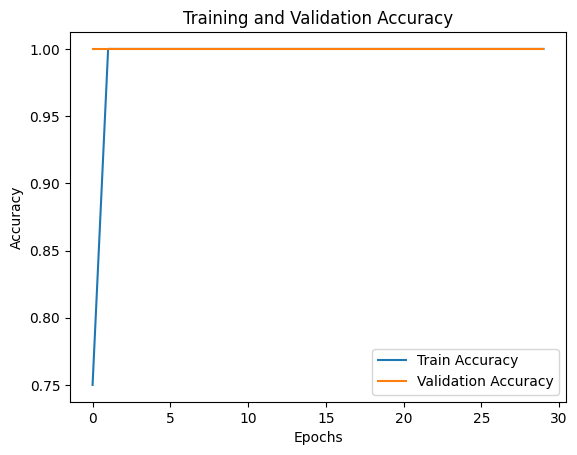

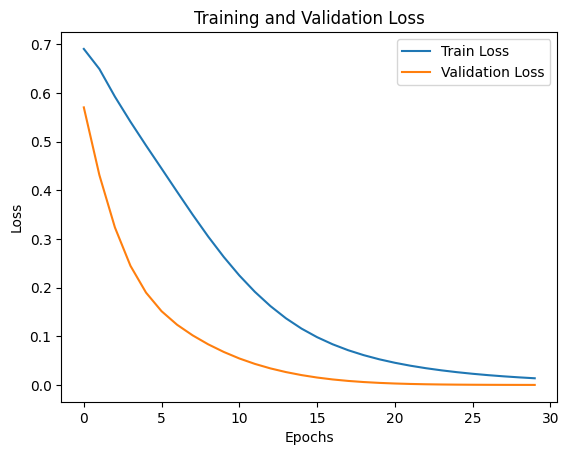

In [119]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### 3 Classes : No Call, Rupe A and Rupe B

## Call Type : Moan

In [121]:
#File index
#file =  '5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file =  'Rupes A and B\\5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file = '5711.211013050024'
#file = 'Rupes A and B\\5713.210825190002'
#file =          'Moan\\5713.210902110002'  #from PPT at time 212 seconds
file = '5713.210902110002'  #from PPT at time 212 seconds

#Read the 2 files
sample_rate, samples = wavfile.read(file+'.wav')
annot_file_path = file +'.Table.1.selections.txt'

#Read the file into a DataFrame
df = pd.read_csv(file +'.Table.1.selections.txt', sep='\t')

#Display the first few rows of the DataFrame
print(df.head())

   Selection           View  Channel  Begin Time (s)  End Time (s)  \
0          1  Spectrogram 1        1      139.054770    139.162684   
1          2  Spectrogram 1        1      136.424374    136.953197   
2          3  Spectrogram 1        1      141.637244    142.016354   
3          4  Spectrogram 1        1      176.545924    176.796172   
4          5  Spectrogram 1        1      210.555520    211.194789   

   Low Freq (Hz)  High Freq (Hz)  Delta Time (s)  Delta Freq (Hz)  \
0         93.085         787.149          0.1079          694.064   
1         84.337         437.751          0.5288          353.414   
2        175.202         363.881          0.3791          188.679   
3        164.474         323.450          0.2502          158.976   
4        131.579         485.175          0.6393          353.596   

   Avg Power Density (dB FS/Hz) Annotation  
0                        -89.96   Type 4 A  
1                        -86.62     Rupe C  
2                        -89.

In [122]:
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=2456, nfft=4096, noverlap=1228, window='hann')       #Try nfft=8192 if computer permits

In [129]:
spectrogram[spectrogram < 0.001] = 0.001    #Trim off all the tiny values so that log scale displays correctly

#Trim in frequency
fmin = 20 # Hz
fmax = 1000 # Hz
freq_slice = np.where((frequencies >= fmin) & (frequencies <= fmax))

#keep only frequencies of interest
frequencies = frequencies[freq_slice]
spectrogram = spectrogram[freq_slice,:][0]

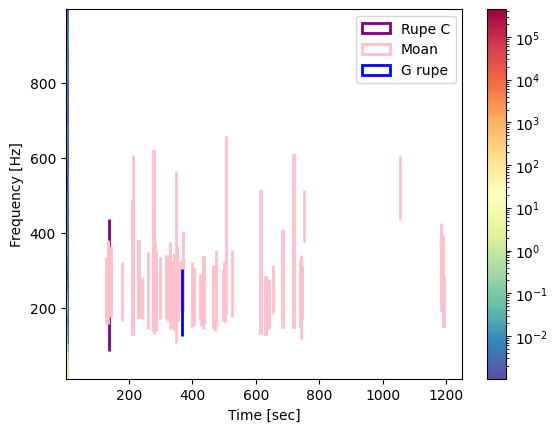

In [130]:
#Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C" : "purple",
    "Moan": "pink",
    "G rupe" : "blue"
}

pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
#pc = plt.pcolormesh(times, frequencies, np.log(spectrogram))
cbar = plt.colorbar(pc)
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#Get the current axes
ax = plt.gca()
overlay_annotations(ax, df, annotation_colors)

#Connect the update function to the axes limit change events
ax.callbacks.connect('xlim_changed', update_colormap)
ax.callbacks.connect('ylim_changed', update_colormap)

plt.show()

(26, 0)


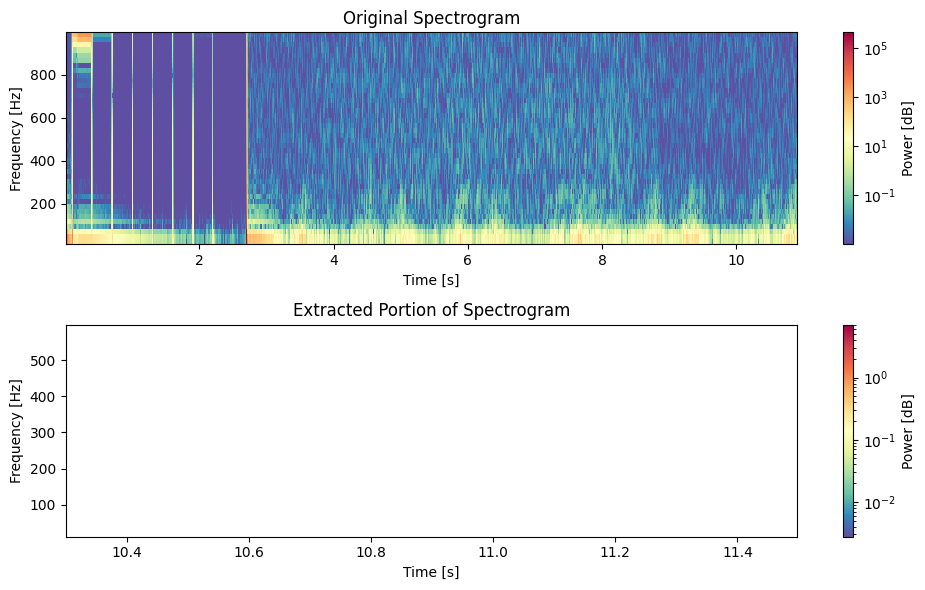

In [131]:
#Define time and frequency limits
time_start, time_end = 210, 216  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
#time_indices = np.where((times >= time_start) & (times <= time_end))[0]

# Find the closest time indices to the desired range if no exact match is found
time_indices = np.where(np.logical_and(times >= time_start, times <= time_end))[0]
if len(time_indices) == 0:
    closest_start_index = np.argmin(np.abs(times - time_start))
    closest_end_index = np.argmin(np.abs(times - time_end))
    time_indices = np.arange(closest_start_index, closest_end_index + 1)

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub_moan = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print(spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub_moan, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()


In [126]:
spectrogram_sub_moan.shape

(25, 1)

Spectrogram size:  (26, 1)


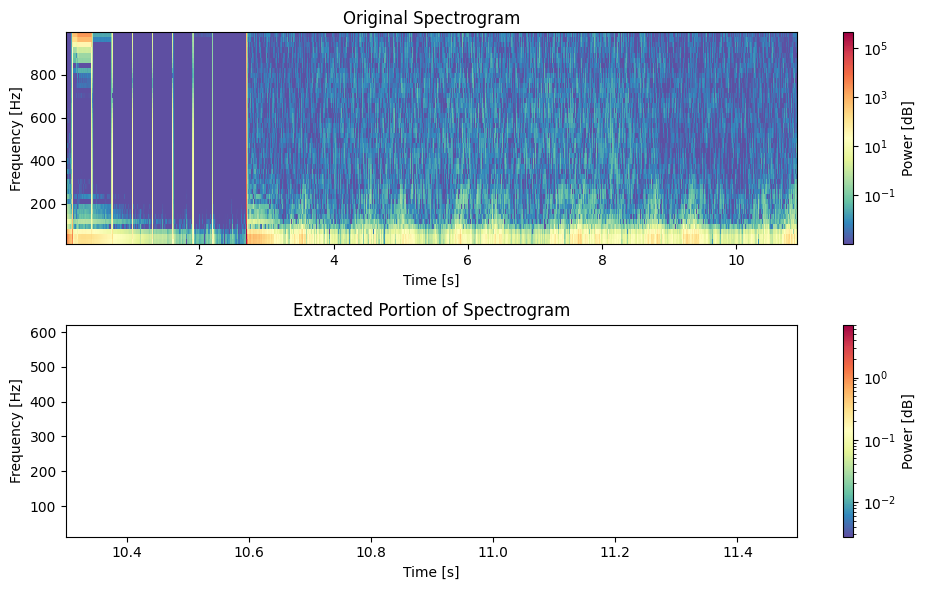

In [127]:
#Define time and frequency limits
time_start, time_end = 212.0, 213.0  # Time range in seconds
freq_start, freq_end = 20, 620  # Frequency range in Hz

#Find indices for the time range
#time_indices = np.where((times >= time_start) & (times <= time_end))[0]

# Find the closest time indices to the desired range if no exact match is found
time_indices = np.where(np.logical_and(times >= time_start, times <= time_end))[0]
if len(time_indices) == 0:
    closest_start_index = np.argmin(np.abs(times - time_start))
    closest_end_index = np.argmin(np.abs(times - time_end))
    time_indices = np.arange(closest_start_index, closest_end_index + 1)

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub_moan = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print("Spectrogram size: ", spectrogram_sub_moan.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub_moan, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()